# Solução - Natural Language Processing with Disaster Tweets

## 1. Tratamento inicial dos dados

In [57]:
#Importando bibliotecas para resolução do problema
import pandas as pd
import numpy as np
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import model_selection

In [58]:
#Lendo dataset de treino
train = pd.read_csv('nlp-getting-started/train.csv')
test = pd.read_csv('nlp-getting-started/test.csv')

In [59]:
#Observando as primeiras amostras do dataset
train.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


#### Sabemos que a coluna target faz uma classificação binária se o tweet é ou não um desastre, isto é: se target = 1, então esta amostra é um desastre; se target = 0, então esta amostra não é um desastre.

,target
0,4342
1,3271


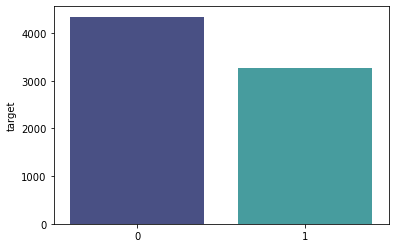

In [60]:
# Contando quantos casos são e quantos não são desastres
VCtrain=train['target'].value_counts().to_frame()

# Fazendo o plot
sns.barplot(data=VCtrain,x=VCtrain.index,y="target",palette="mako")
VCtrain

#### Podemos perceber que as quantidades para cada caso não são tão discrepantes, isto é, as quantidades de desastres e não desastres estão balanceadas.

In [61]:
#Tamanho do dataset
train.shape

(7613, 5)

In [62]:
#Soma de valores faltantes para cada coluna
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

#### Como os valores faltantes se concentram em 'location' e 'keyword', que são campos onde se torna difícil estipular valores, tendo em vista que se trata da localização e da palavra central do tweet, optou-se por colocar espaço vazio nestes campos preservando os textos destas amostras que também são importantes para o dataset de treino.

In [63]:
#Colocando espaço vazio nos valores faltantes
train.fillna('', inplace = True)
test.fillna('',inplace=True)

#### Como a coluna id não traz nenhuma informação relevante para a resolução do problema, optou-se por realizar a eliminação desta coluna, assim como as colunas id, keyword e location em test.

In [64]:
#Removendo coluna id de train
train.drop(columns=['id'],inplace=True)
#Removendo colunas id keyword e location de test
test.drop(columns=['id','keyword','location'],inplace=True)

#### Removendo pontuação

In [65]:
#Definindo função para remover pontuação dos textos
def remove_pontuacao(text):
    livre_de_pontuacao="".join([i for i in text if i not in string.punctuation])
    return livre_de_pontuacao
#Aplicando a função remove_pontuacao na coluna 'text' do dataset com auxílio da expressão lambda
train['text']= train['text'].apply(lambda x:remove_pontuacao(x))
test['text']= test['text'].apply(lambda x:remove_pontuacao(x))

#### Transformando o texto em caixa baixa

In [66]:
#Colocando as amostras de texto da coluna 'text' em caixa baixa com auxílio da expressão lambda
train['text']= train['text'].apply(lambda x: x.lower())

#### Tokenização

In [67]:
# Definindo função de tokenização
def tokeniza(string):
    tokens = string.split()
    return tokens

In [68]:
# Aplicando a função de tokenização na coluna 'text' e na coluna 'keyword'
train['text']= train['text'].apply(lambda x: tokeniza(x))
train['keyword']= train['keyword'].apply(lambda x: tokeniza(x))
test['text']= test['text'].apply(lambda x: tokeniza(x))

In [69]:
# Verificando alteração realizada pela função
train.head()

,keyword,location,text,target
0,[],,"[our, deeds, are, the, reason, of, this, earth...",1
1,[],,"[forest, fire, near, la, ronge, sask, canada]",1
2,[],,"[all, residents, asked, to, shelter, in, place...",1
3,[],,"[13000, people, receive, wildfires, evacuation...",1
4,[],,"[just, got, sent, this, photo, from, ruby, ala...",1


#### Stemming

In [70]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
def stemming(text):
    stem_text = [porter_stemmer.stem(word) for word in text]
    return stem_text
train['text']=train['text'].apply(lambda x: stemming(x))
test['text']= test['text'].apply(lambda x: stemming(x))

#### Vetorização de textos

In [71]:
# Convertendo os tokens para string para colocar no Count Vectorizer
train['text_strings'] = train['text'].apply(lambda x: ' '.join([str(elem) for elem in x]))
test['text_strings'] = test['text'].apply(lambda x: ' '.join([str(elem) for elem in x]))

In [72]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train['text_strings'])
x_test = vectorizer.transform(test['text_strings'])

## 2. Preparando os conjuntos e treinando com o método

#### Definindo os valores de treinamento e validação para o método

In [73]:
# Com isto transformamos o texto em vetor
x_train = X.toarray()
x_test = x_test.toarray()

In [74]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(x_train, train['target'], test_size=0.3)

In [75]:
# Este conjunto pode ser usado direto no método de treino
#x_train = np.array(x_train)
#x_test = np.array(x_test)

In [76]:
#y_train = train['target']

#### Conferindo dimensão dos conjuntos

In [77]:
Train_X.shape


(5329, 19388)

In [78]:
Train_Y.shape

(5329,)

#### Ambos com mesma quantidade de observações.

#### Treinando e testando o método

In [79]:
clf = LogisticRegression(random_state=42)
clf.fit(Train_X,Train_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [80]:
pred = clf.predict(Test_X)

In [89]:
# Medindo a acurácia e f1
print("Accuracy Score -> ", accuracy_score(Test_Y, pred)*100)
print("F1 Score       -> ", f1_score(Test_Y, pred)*100)

Accuracy Score ->  80.29772329246934
F1 Score       ->  75.91006423982869


**Fazendo as predições para a resposta**

In [90]:
y_test_pred = clf.predict(x_test)

## 3. Colocando as predições no arquivo .csv

In [92]:
submission = pd.read_csv('nlp-getting-started/test.csv')

resp = pd.DataFrame({'id': np.array(submission.id), 'target': y_test_pred})

from numpy import savetxt
resp.to_csv('resposta - regressao logistica.csv', index=False)

# Score Final

0.79007